<a href="https://colab.research.google.com/github/mbajdman/Data-Science-Portfolio/blob/main/Employee_Churn_HR_Department.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salifort Motors - Predicting Employee Turnover for HR department

![turnover](https://whatfix.com/blog/wp-content/uploads/2022/09/employee-churn.png)

## **Pace: Plan Stage**


### Company  and the business scenario

Salifort Motors, a fictional French-based manufacturer of alternative energy vehicles, is experiencing a high rate of employee turnover. Concerned about the reasons behind this, the senior leadership team is eager to understand why many employees are leaving, whether they are resigning or being let go. The high turnover rate is financially burdensome, as the process of hiring, interviewing, and training new employees is both time-consuming and expensive.

Salifort aims to cultivate a corporate culture that supports employee success and professional development while enhancing employee satisfaction and retention. If Salifort could predict which employees are likely to leave and identify the factors contributing to their departure, they could address the issue more effectively.

The HR department at Salifort Motors is keen to improve employee satisfaction and has collected data from employees. They have tasked the data analytics team with providing data-driven insights. Their key question is: what factors are likely to cause employees to leave the company?

###  About the dataset

The dataset **"HR_capstone_dataset.csv"** contains 15,000 rows and 10 columns for the variables listed below.

The original data source reference:
https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

**Stakeholders**

- HR department
- Senior leadership team

### Import packages

In [ ]:
# Import packages
!pip install xgboost --trusted-host pypi.org --trusted-host files.pythonhosted.org
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

### Load dataset

In [ ]:
# Load dataset into a DataFrame
df0 = pd.read_csv("HR_capstone_dataset.csv")

# Display the first few rows of the dataset
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## EDA -  data exploration and cleaning

- Understand the variables
- Clean the dataset (missing data, redundant data, outliers)



### Gather basic information about the data

In [ ]:
# Basic information about the data

df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Gather descriptive statistics about the data

In [ ]:
# Gather descriptive statistics about the data
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,3.803054,1.232592,2.00,3.00,4.00,5.00,7.0
average_montly_hours,14999.0,201.050337,49.943099,96.00,156.00,200.00,245.00,310.0
time_spend_company,14999.0,3.498233,1.460136,2.00,3.00,3.00,4.00,10.0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,1.0
left,14999.0,0.238083,0.425924,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,1.0


 - number of projects goes between  minimum 2 and maximum 7 and mean 3.5.
 - average monthly hours worked are in the range of 96-310 hrs with mean 201 hrs.
 - time spend in company goes between minimum 2 and maximum 10 years.

In [ ]:
# For categorical features
print('Departments: \n', df0['Department'].describe(),
      '\nDepartments names: \n',
      ', '.join(df0['Department'].unique()))


# For categorical features
print('\nSalary: \n', df0['salary'].describe(),
      '\nSalary categories: \n',
      # Joins the unique salary values, converted to strings, with a comma and a space.
      ', '.join(map(str, df0['salary'].unique())))

Departments: 
 count     14999
unique       10
top       sales
freq       4140
Name: Department, dtype: object 
Departments names: 
 sales, accounting, hr, technical, support, management, IT, product_mng, marketing, RandD

Salary: 
 count     14999
unique        3
top         low
freq       7316
Name: salary, dtype: object 
Salary categories: 
 low, medium, high


### Rename columns

As part of the data cleaning process, rename the columns as necessary. Ensure that all column names are standardized to 'snake_case', correct any misspellings, and make the column names more concise where appropriate.

In [ ]:
# Rename columns
df0 = df0.rename(columns={'average_montly_hours':'average_monthly_hours',
                          'time_spend_company':'tenure',
                          'project_contribution':'number_project',
                         'Work_accident': 'work_accident',
                         'Department':'department'})
# Display the modified column names
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

Check for any missing values in the data.

In [ ]:
# Check for missing values
df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

Now we can check for any duplicate entries in the data.

In [ ]:
# Check for duplicates
df0.duplicated().sum()

3008

 - We observe no missing values, however there are 3008 duplicated rows.

In [ ]:
# Rows inspection
df0[df0.duplicated()].head(10)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low
1516,0.40,0.50,2,127,3,0,1,0,IT,low
1616,0.37,0.46,2,156,3,0,1,0,sales,low
1696,0.39,0.56,2,160,3,0,1,0,sales,low
1833,0.10,0.85,6,266,4,0,1,0,sales,low
12000,0.38,0.53,2,157,3,0,1,0,sales,low


In [ ]:
# Dropping duplicates that could affect our model and save resulting DataFrame in a new variable as needed
df1 = df0.drop_duplicates(keep='first')
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Check outliers

Check for outliers in the data.

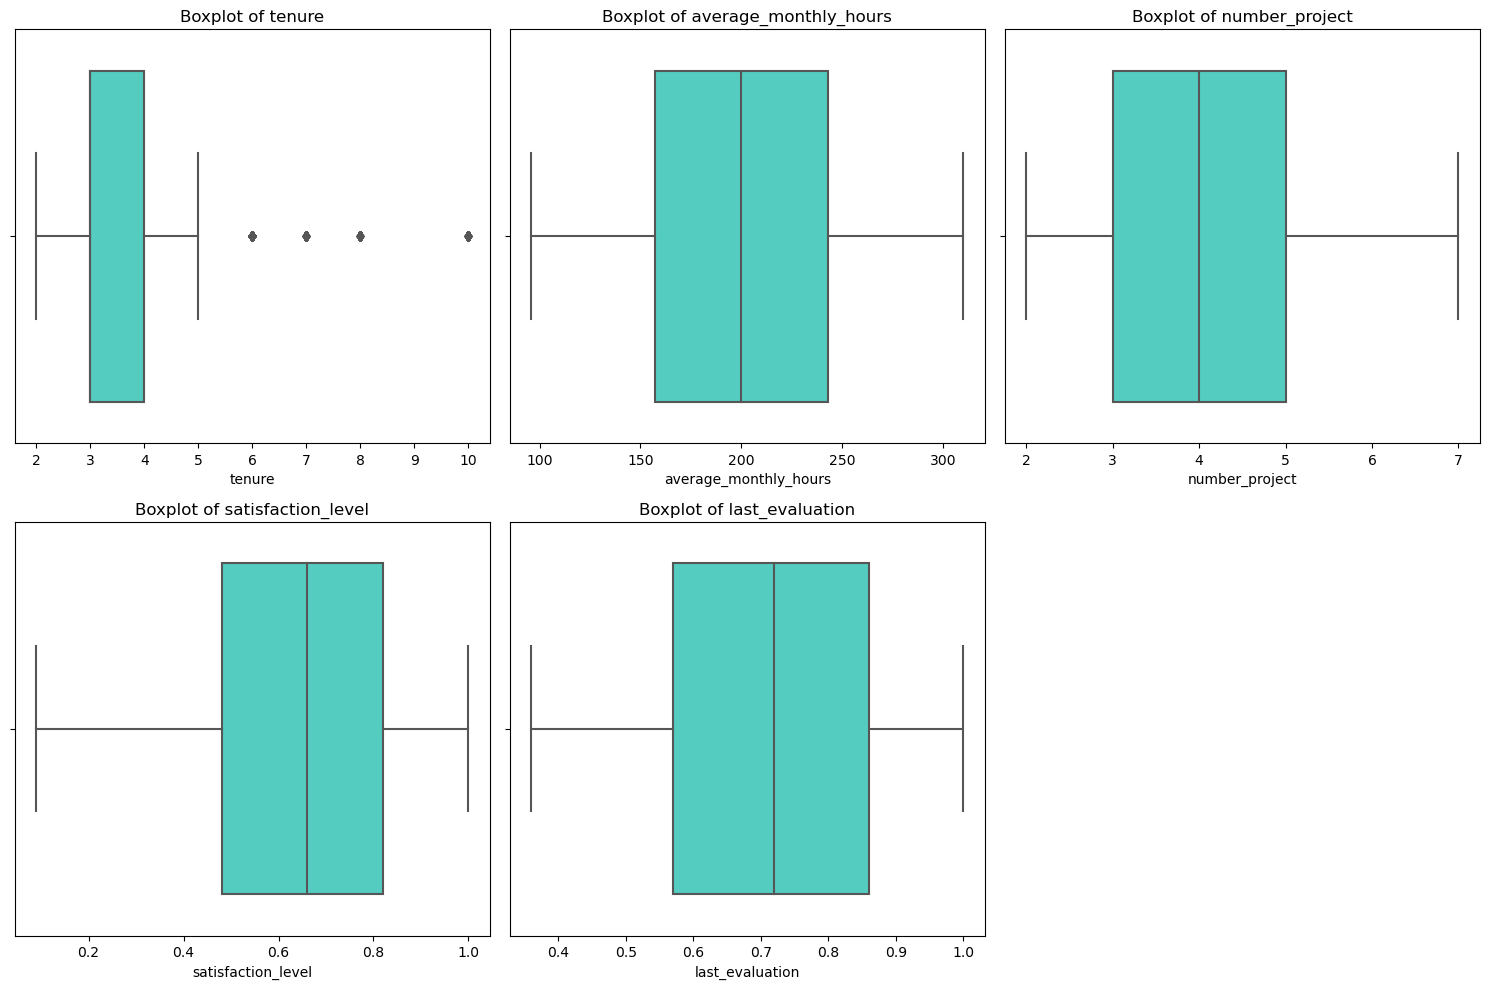

In [ ]:
# Data for plotting
plot_data = {
    'tenure': "Boxplot of tenure",
    'average_monthly_hours': "Boxplot of average_monthly_hours",
    'number_project': "Boxplot of number_project",
    'satisfaction_level': "Boxplot of satisfaction_level",
    'last_evaluation': "Boxplot of last_evaluation"
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten 2D array of axes to 1D to simplify the process of iterating over each subplot with single loop.
axes_flat = axes.flatten()

# Use the loop to iterate over each axis and the items in plot_data,
# creating a boxplot for each column and setting the corresponding title.

# 'ax' represents current subplot axis.
# (col_name, title) unpacked tuple from dictionary items.
for ax, (col_name, title) in zip(axes_flat, plot_data.items()):
    sns.boxplot(x=df1[col_name], ax=ax, color='turquoise')
    ax.set_title(title)

# Turn off the last unused subplot
axes_flat[-1].axis("off")

# Adjust layout and display
plt.tight_layout()
plt.show()



There appear to be outliers in the 'tenure' field. We should investigate how many rows in that field contain outliers. It's important to conduct this procedure because outliers can significantly impact the performance of ML models, causing models to be overly sensitive to individual data points, leading to poor generalization on unseen data. Outliers can distort the overall distribution, affect measures of central tendency (mean, median), and influence variance estimation. Additionally, they might violate assumptions of normally distributed data, which can lead to biased estimates or incorrect conclusions if not addressed properly.

In [ ]:
# Calc of 25th & 75th percentile
q1 = df1['tenure'].quantile(0.25)
q3 = df1['tenure'].quantile(0.75)
# Calc of Interquartile range
iqr = q3 - q1

# Calc of lower & upper bounds
lower_bounds = q1 - 1.5 * iqr
upper_bounds = q3 + 1.5 * iqr
print('Lower limit:', lower_bounds)
print('Upper limit:', upper_bounds)

# Identify outliers
outliers = df1[(df1['tenure'] > upper_bounds) | (df1['tenure'] < lower_bounds)]
num_outliers = len(outliers)
total_rows = len(df1['tenure'])

print('Number of rows containing outliers:', len(outliers))

# Calculate the percentage of outliers
percentage_outliers = (num_outliers / total_rows) * 100
print('Percentage of outliers in the tenure column:', round(percentage_outliers,2),"%")

Lower limit: 1.5
Upper limit: 5.5
Number of rows containing outliers: 824
Percentage of outliers in the tenure column: 6.87 %


**Result of EDA**

- We obrserve no missing value & 3008 duplicated rows.
- We found 824 records containing outliers that makes it 6.87% of the total count of 'tenure'.
- Employees with less than 1.5 years or more than 5.5 years of tenure are considered outliers in this case.

Certain types of models are more sensitive to outliers than others. When you reach the stage of building your model, consider whether to remove outliers based on the type of model you choose to use.

In [ ]:
df1['tenure'].value_counts().sum()

11991

# pAce: Analyze Stage




We can start off with the understanding of how many employees left and what percentage of all employees this figure represents.

In [ ]:
# Numbers of people who left vs. stayed
print(df1['left'].value_counts())
print()
# Percentages of people who left vs. stayed
print(round(df1['left'].value_counts(normalize=True)*100, 2))

0    10000
1     1991
Name: left, dtype: int64

0    83.4
1    16.6
Name: left, dtype: float64


### Data visualizations

Now, investigate the variables that interest us and generate plots to visualize the relationships between them in the data.

Let's create a stacked boxplot showing average_monthly_hours distributions for number_project, comparing the distributions of employees who stayed versus those who left.

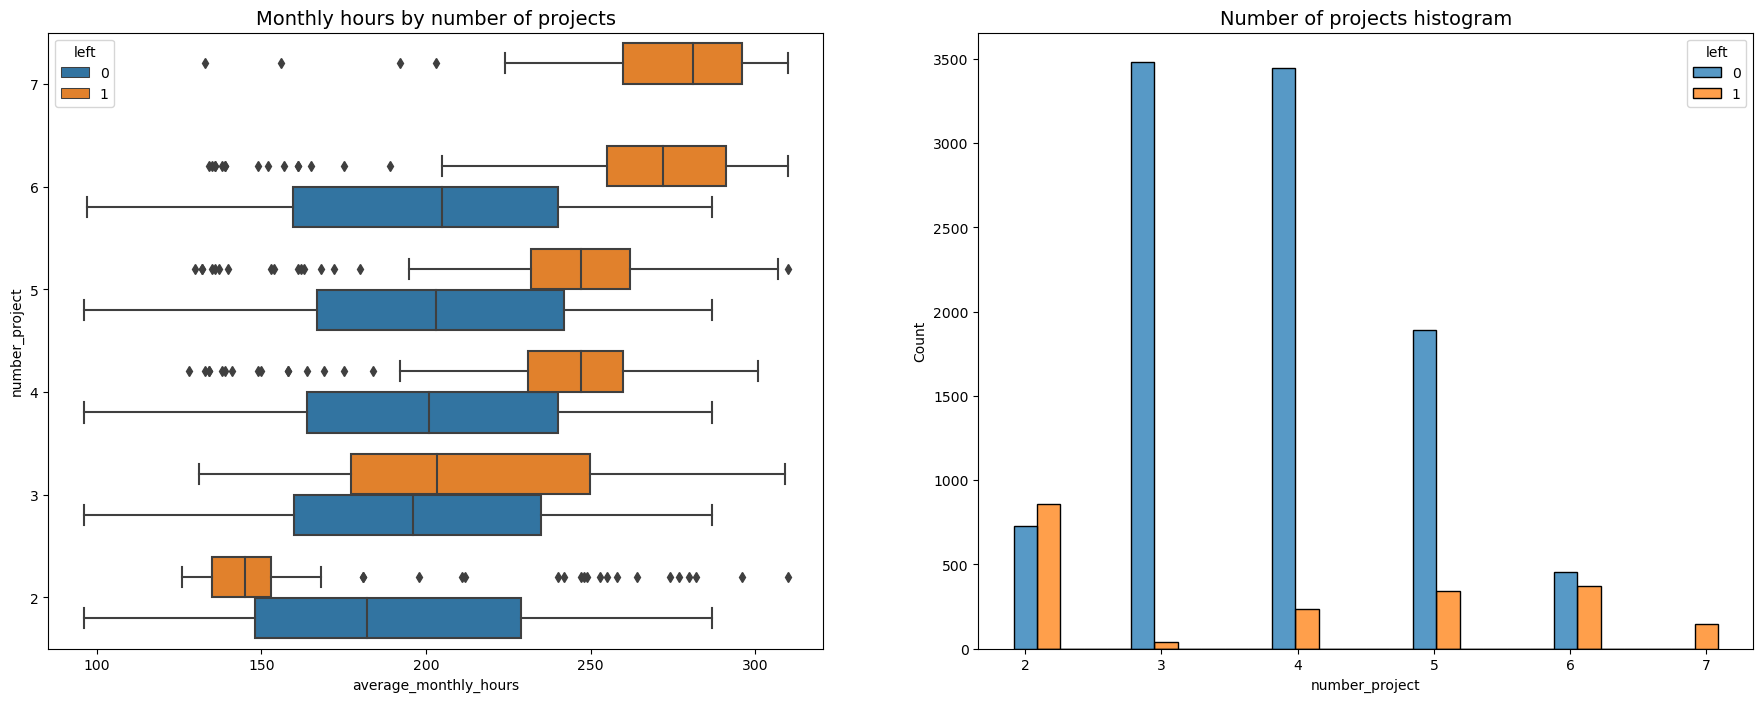

In [ ]:
# Figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Boxplot showing `average_monthly_hours` distributions for `number_project`,
# comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

# Histogram showing distribution of `number_project`, comparing employees who stayed versus
# those who left
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

plt.show()


- Employees who left the organization fell into two main categories:
  - Some worked significantly fewer hours compared to peers with similar project involvement.
  - Others worked considerably more, likely voluntarily resigning after making substantial project contributions.

- All employees with seven projects left the company. The interquartile range for those with six or seven projects was 255 to 295 hours per month, significantly higher than other groups.

- Optimal employee performance is observed with 3–4 projects, evidenced by a low turnover rate among these groups.

- Assuming a standard work week of 40 hours and two weeks of vacation per year:
  - The average monthly working hours for Monday–Friday employees is 166.67 hours.
  - Except for those working on two projects, all other groups, including those who stayed, worked significantly more, suggesting potential overwork.

It might be natural that people who work on more projects would also work longer hours. The mean hours of each group (stayed and left) increasing with number of projects worked. However, a few things stand out from this plot.

1. There are two categories of employees who have left the organization: (A) those who worked significantly fewer hours compared to their peers with similar project involvement, and (B) those who worked considerably more. Within group A, it's plausible that some were terminated. Alternatively, this group might also include individuals who had already resigned and were given reduced workload as they approached their departure. As for group B, it's likely they voluntarily resigned. Employees in group B probably made substantial contributions to their projects, potentially being key contributors.

2. All employees who had seven projects left the company. The interquartile range for this group, as well as for those who left with six projects, was approximately 255 to 295 hours per month, significantly higher than any other group.

3. Employees appear to perform optimally when working on 3–4 projects. The ratio of those who left to those who stayed is notably low within these groups.

4. Assuming a standard work week of 40 hours and two weeks of vacation per year, the average monthly working hours for employees working Monday–Friday can be calculated as follows: 50 weeks * 40 hours per week / 12 months = 166.67 hours per month.This suggests that, apart from employees working on two projects, every other group, including those who remained with the company, worked significantly more hours than this average. This observation implies that employees may be experiencing overwork.

In [ ]:
# Let's confirm that every employee with 7 projects left the company
df1[df1['number_project']==7]['left'].value_counts()

1    145
Name: left, dtype: int64

We have confirmed that all employees with 7 project did leave.

Next, the examination of average mothly hours versus the satisfaction levels.

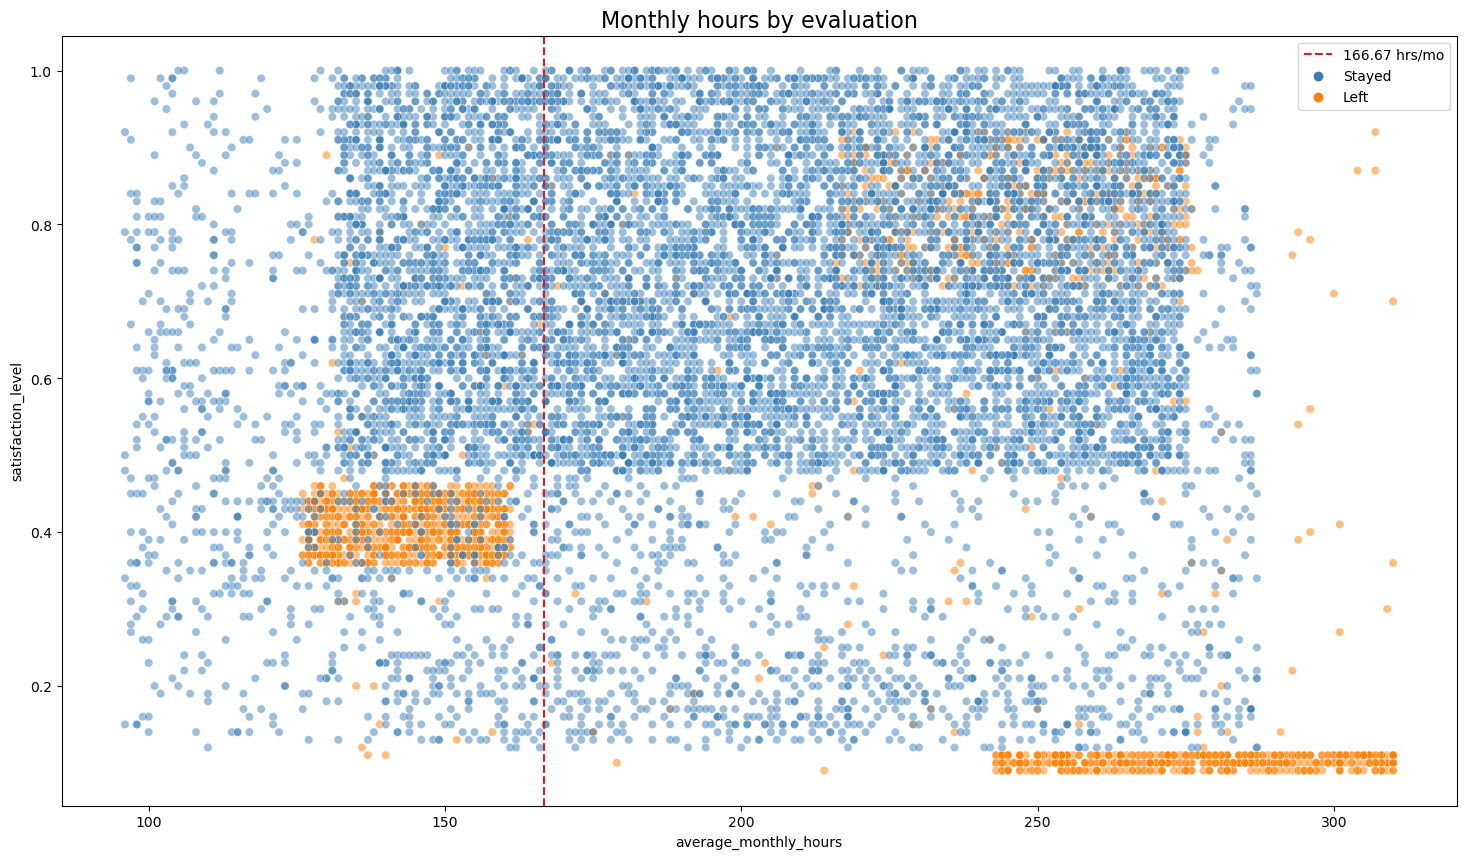

In [ ]:
# Scatterplot of 'average_monthly_hours' versus 'satisfaction_level', comparing employees who stayed versus those who left
plt.figure(figsize=(18, 10))
scatter=sns.scatterplot(
    data=df1, x='average_monthly_hours', y='satisfaction_level',
    hue='left', palette={0: '#377eb8', 1: '#ff7f00'}, alpha=0.5
)
vline = plt.axvline(x=166.67, color='#e41a1c', label='166.67 hrs/mo', ls='--')

# Create custom legend
handles, _ = scatter.get_legend_handles_labels()
plt.legend(handles=[vline] + handles, labels=['166.67 hrs/mo', 'Stayed', 'Left'])

plt.title('Monthly hours by evaluation', fontsize=16)
plt.show()

The scatterplot indicates a significant group of employees who worked between 240 and 315 hours per month. Working 315 hours per month equates to over 75 hours per week throughout the year. This heavy workload likely contributed to their near-zero satisfaction levels.


The plot also reveals another group of individuals who left the organization, despite having more regular working hours. Their satisfaction level was only about 0.4. It is challenging to determine the exact reasons for their departure. One possibility is that they felt pressured to work longer hours due to the high number of peers who did so, potentially leading to lower satisfaction levels.

Finally, there is a group who worked approximately 210 to 280 hours per month, with satisfaction levels ranging from about 0.7 to 0.9.

The unusual shape of data distributions indicates either synthetic or manipulatd data.


Let's visualize satisfaction levels by tenure.

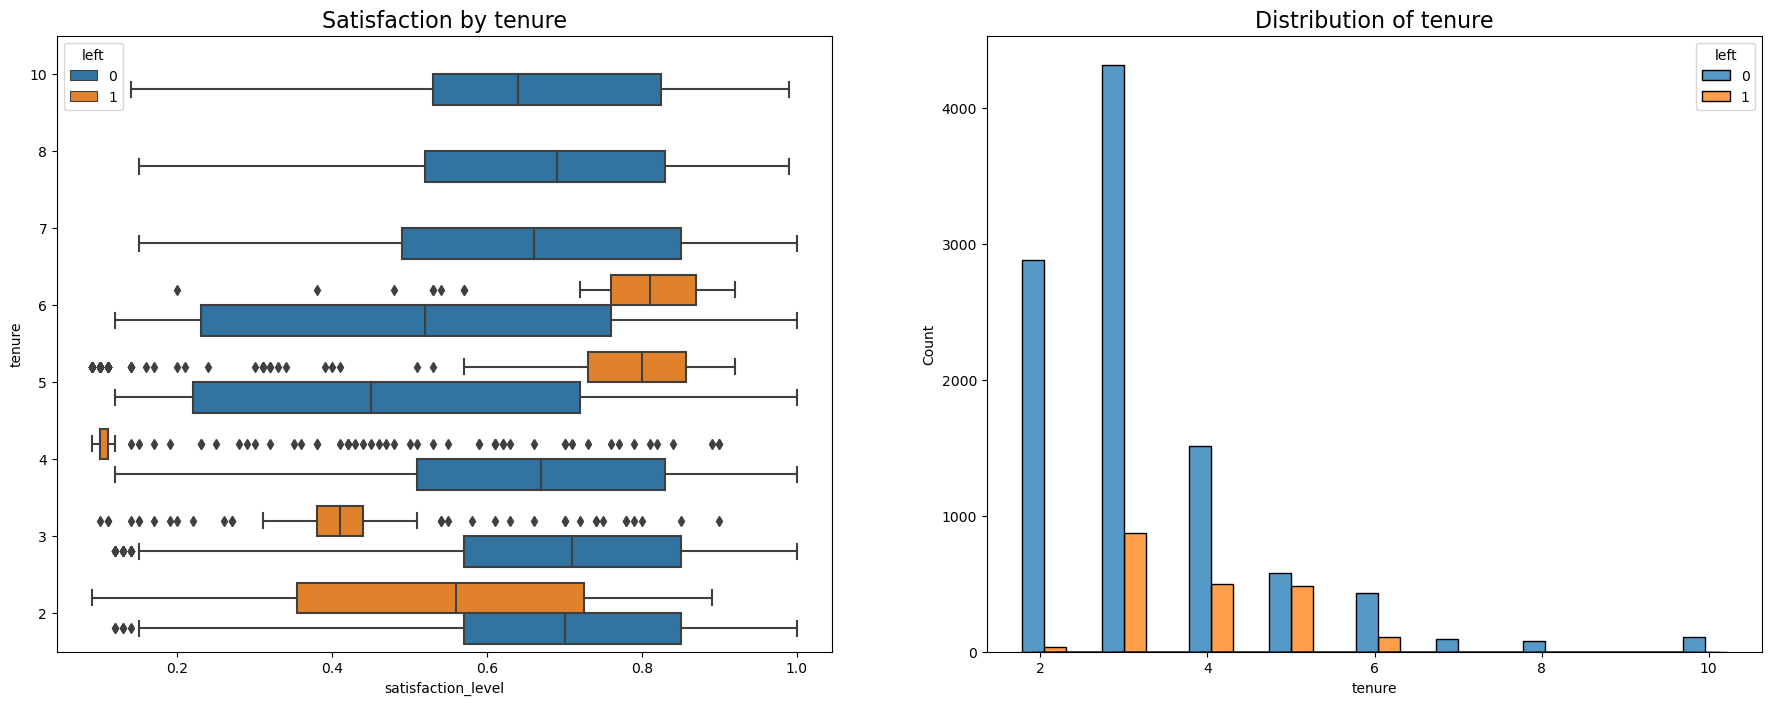

In [ ]:
# Setting figure and axes
fig, ax = plt.subplots(1,2, figsize=(22,8))

# Boxplot showing distributions of `satisfaction_level` by tenure, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='left', orient='h',ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize=16)

# Histogram showing distribution of `tenure`, comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['tenure']
tenure_left = df1[df1['left']==1]['tenure']
sns.histplot(data=df1, x='tenure', hue='left', multiple='dodge', shrink=6, ax=ax[1])
ax[1].set_title('Distribution of tenure', fontsize=16)
plt.show()

- We can observed two general groups of people who left: dissatisfied with shorter tenures and satisfied with medium-length tenures.
- Worth of investigation are four-year employees who left with significant low satisfaction level.
- The employees with the longest tenure did not leave. Their satisfaction levels were similar to those of newer employees who remained with the company.
- The histogram indicates that there are relatively few employees with longer tenure. It's possible that these individuals hold higher-ranking, higher-paid positions


As the next step, we can calculate the mean and median satisfaction score of employees who left and who did not.


In [ ]:
# Calculation of mean & median satisfaction scores of employees who left and those whose stayed.
df1.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


As expected median and mean satisfaction scores of employees who left are lower than of those who stayed.
We can see the median is slightly higher above the mean in employees who stayed, that indicates that satisfaction score between those who stayed might be skewed to the left

Next, we will examine salary levels for different tenures.

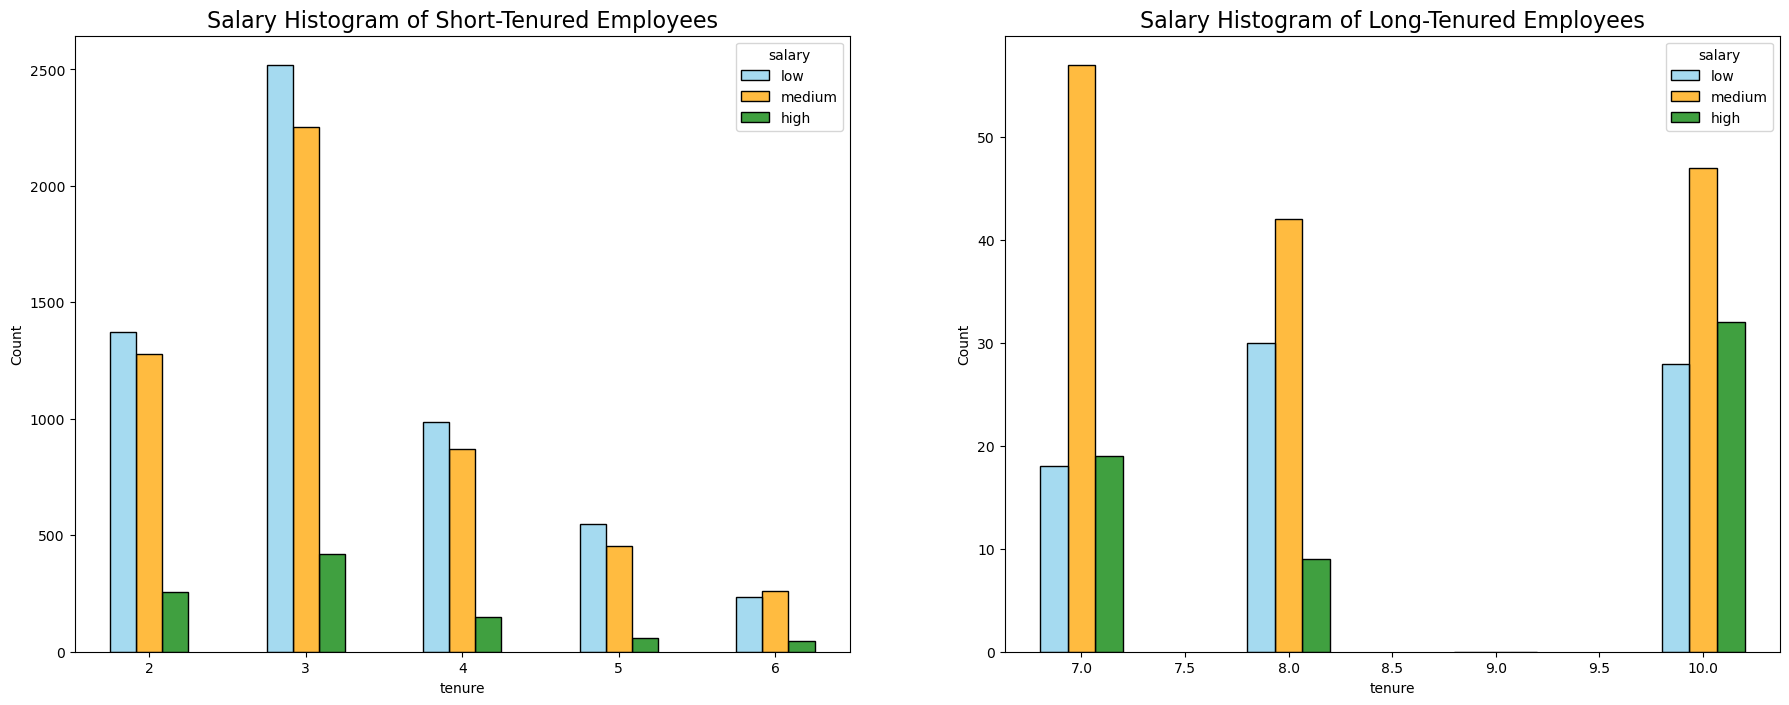

In [ ]:
# Histograms of long and short tenures

fig, ax =plt.subplots(1,2,figsize=(22,8))

# Short-tenurd employees
short_tenure = df1[df1['tenure'] < 7]
# Long-tenured employees
long_tenure = df1[df1['tenure'] > 6]

# Define custom colors for the hue categories
custom_palette = {'low': 'skyblue', 'medium': 'orange', 'high': 'green'}

# Short-tenured histogram
sns.histplot(
    data=short_tenure, x='tenure', hue='salary', discrete=True,
    hue_order=['low', 'medium', 'high'], palette=custom_palette,
    multiple='dodge', shrink=0.5, ax=ax[0]
)
ax[0].set_title('Salary Histogram of Short-Tenured Employees', fontsize=16)

# Long-tenured histogram
sns.histplot(
    data=long_tenure, x='tenure', hue='salary', discrete=True,
    hue_order=['low', 'medium', 'high'],palette=custom_palette,
    multiple='dodge', shrink=0.4, ax=ax[1]
)
ax[1].set_title('Salary Histogram of Long-Tenured Employees', fontsize=16)

plt.show()

The plots above indicate that long-tenured employees were not predominantly higher-paid employees.

Next, we explore whether there is a correlation between working long hours and receiving high evaluation scores by help of scatterplot.

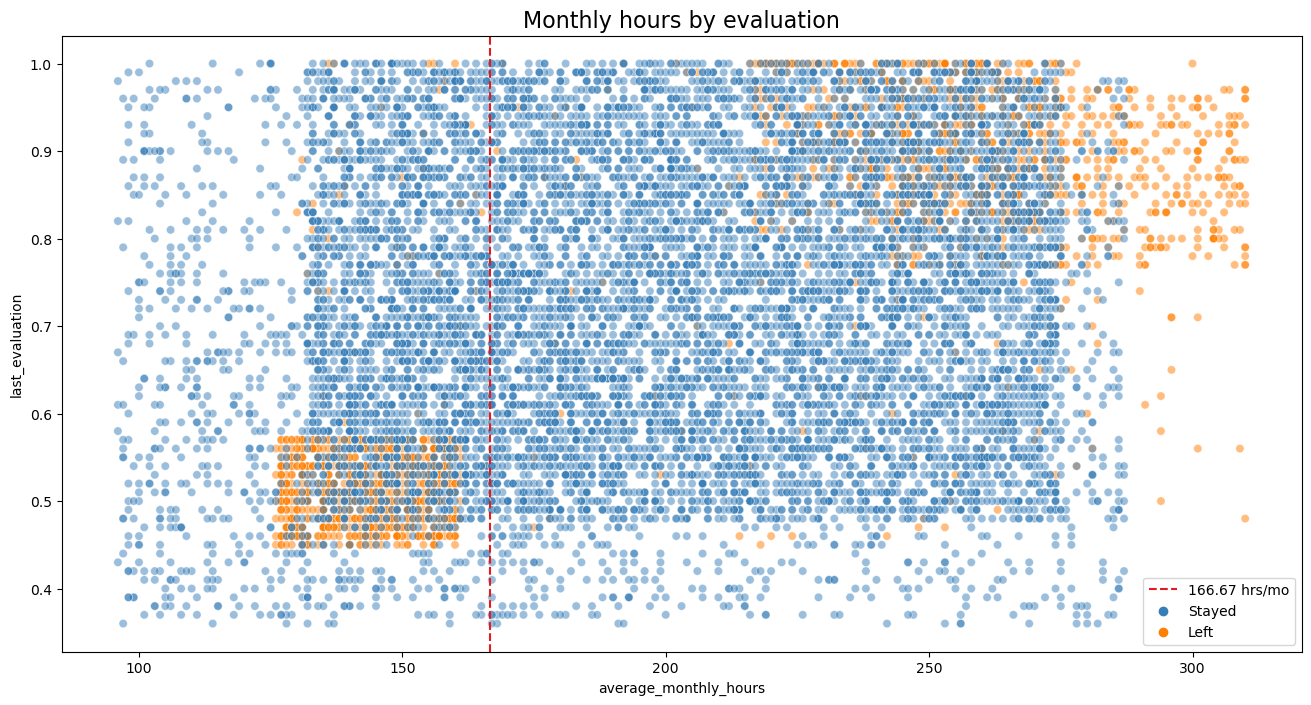

In [ ]:
# Scatterplot of average_monthly_hours versus last_evaluation
plt.figure(figsize=(16, 8))
scatter = sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left',
                          palette={0: '#377eb8', 1: '#ff7f00'}, alpha=0.5)
vline = plt.axvline(x=166.67, color='#e41a1c', label='166.67 hrs/mo', ls='--')

# Create custom legend
handles, _ = scatter.get_legend_handles_labels()
plt.legend(handles=[vline] + handles, labels=['166.67 hrs/mo', 'Stayed', 'Left'])

plt.title('Monthly hours by evaluation', fontsize=16)
plt.show()

- The scatterplot reveals two distinct groups of employees who left: those who were productive and overworked, and those who worked slightly below average of 166.67 hours per month with lower evaluation scores.
- A correlation between hours worked and evaluation score appears evident.
- However, the upper left quadrant of the plot has a low concentration of employees, but working long hours does not ensure high evaluation score.
- Notably, most people in the company work well beyond 167 hours per month.

Now, we will examine whether employees that worked very long hours were promoted in the last five years.

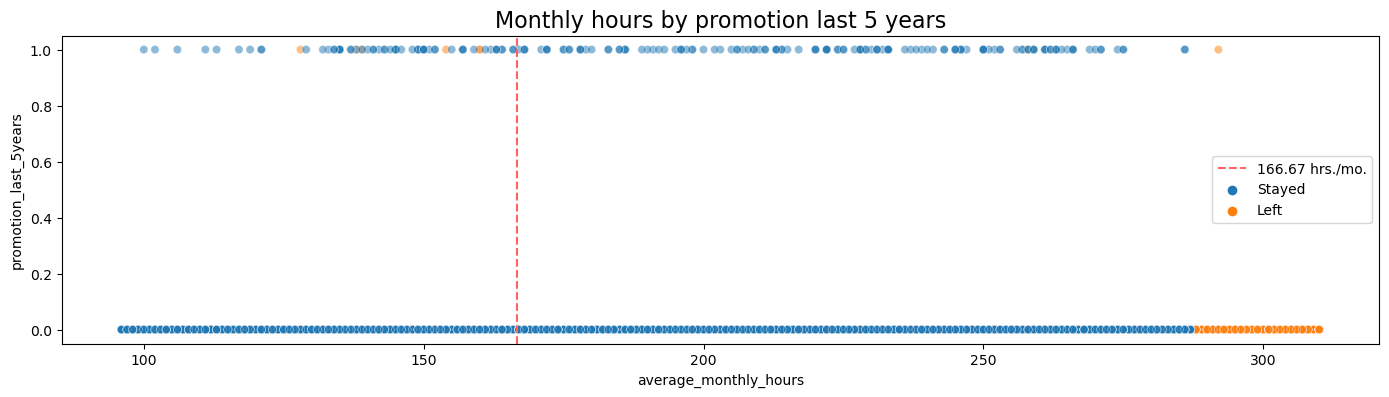

In [ ]:
# Scatterpolot - examination of relationship between 'average_montthly_hours' and 'promotion in last 5years'
plt.figure(figsize=(17, 4))
scatter = sns.scatterplot(data=df1, x='average_monthly_hours', y='promotion_last_5years',
                          hue='left', alpha=0.5)
vline = plt.axvline(x=166.67, color='#ff6361', ls='--', label='166.67 hrs./mo.')

# Create custom legend
handles, _ = scatter.get_legend_handles_labels()
plt.legend(handles=[vline] + handles, labels=['166.67 hrs./mo.', 'Stayed', 'Left'])

plt.title("Monthly hours by promotion last 5 years", fontsize=16)
plt.show()

We can observe the following from the plot:
-     very few employees who got promoted in last 5 years left the company
-     employees that worked longest hours they all left
-     very few employees who worked long hours were promoted

Next, we inspect how the employees who left are distributed across departments.

In [ ]:
df1['department'].value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: department, dtype: int64

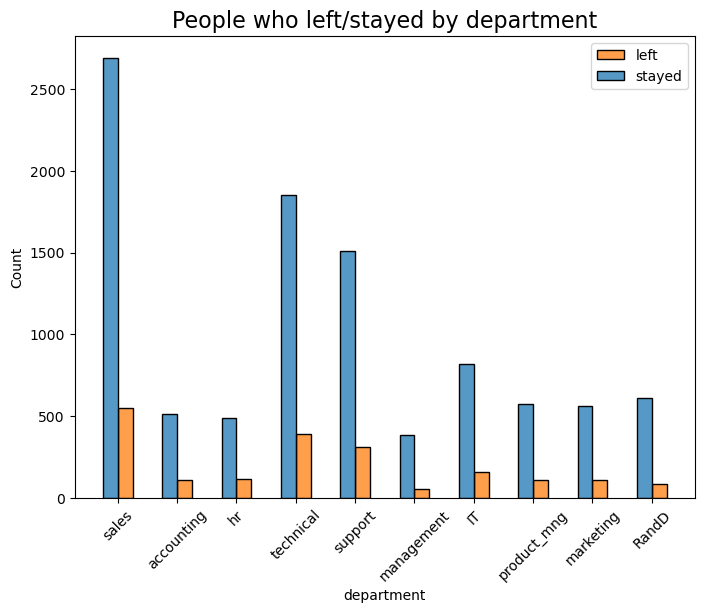

In [ ]:
# Histogram for department distribution of employees who left
plt.figure(figsize=(8,6))
sns.histplot(data=df1, x='department', hue='left', multiple='dodge',
            shrink=0.5, hue_order=[0,1])
plt.xticks(rotation=45)
plt.legend(labels=['left', 'stayed'])
plt.title('People who left/stayed by department', fontsize=16);

There doesn't appear to be any department with a significantly different proportion of employees who left compared to those who stayed

At the end we check for correlation between predictors in the data.


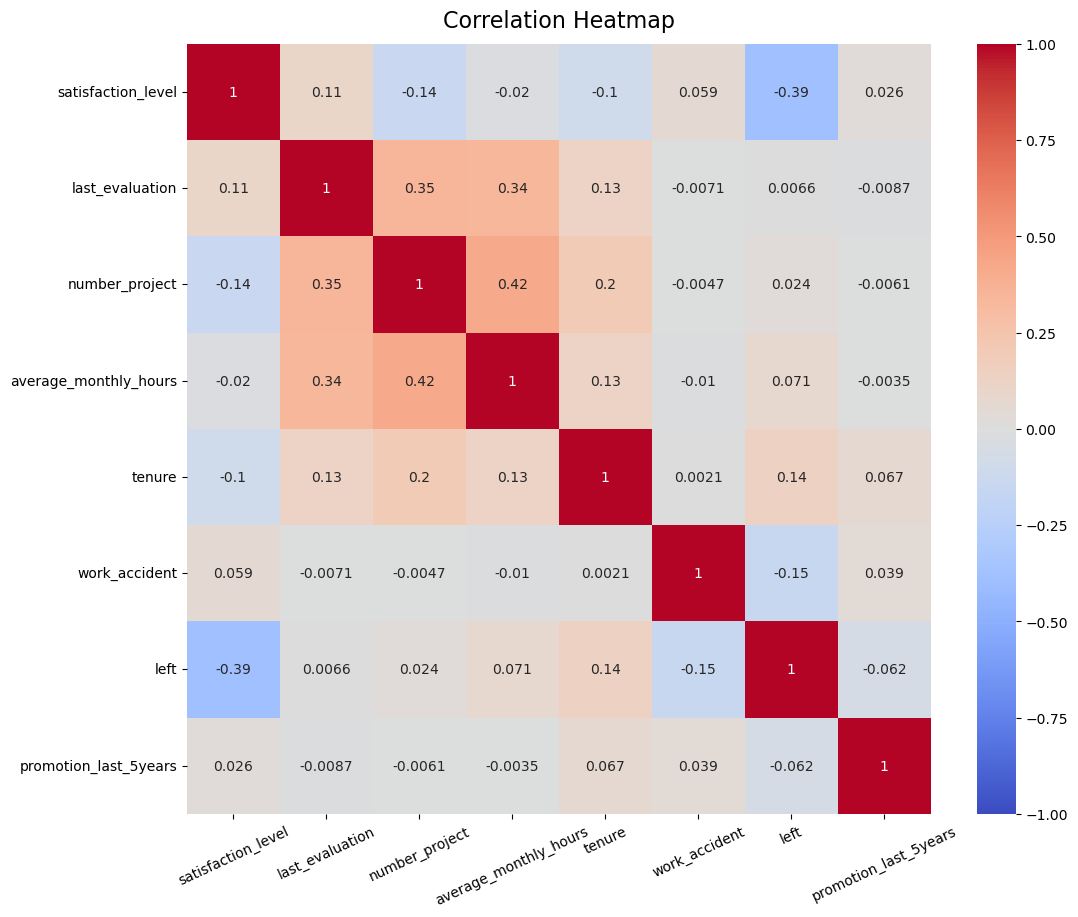

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df0.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap="coolwarm")
plt.title('Correlation Heatmap', fontsize=16, pad=12)
plt.xticks(rotation=25)
plt.show()

The correlation heatmap reveals that the number of projects, monthly hours, and evaluation scores all exhibit some positive correlation with each other. Additionally, it shows that an employee's likelihood of leaving is negatively correlated with their satisfaction level.

### EDA Insights

It seems that employees are leaving the company due to poor management. Departure is associated with longer working hours, numerous projects, and generally lower satisfaction levels. Working long hours without receiving promotions or good evaluation scores can be demoralizing. There is a significant group of employees likely experiencing burnout. Additionally, employees who have been with the company for more than six years tend to stay.

# paCe: Construct Stage
- Determine which models are most appropriate
- Construct the model
- Confirm model assumptions
- Evaluate model results to determine how well your model fits the data


## Model Building


### Identify the type of prediction task.

Our goal is to predict whether an employee will leave the company, which is a categorical outcome variable. Therefore, this task involves classification. Specifically, it involves binary classification, as the outcome variable "left" can either be 1 (indicating the employee left) or 0 (indicating the employee did not leave).

### Identify the types of models most appropriate for this task.

Since the variable we want to predict is categorical, we could either build a Logistic Regression model, or a Tree-based ML model.

### Logistic Regression

Logistic Regression - binary classification

We need to encode the non-numeric variables, department and salary.

- department is suitable for dummy process, because it's categorical variable.
- salary is suitable for the conversion of the levels to 0-2, not for dummy though, bacause it's categorical and ordinal, so there's an order(hierarchy) in categories.

In [ ]:
# Copy DataFrame
df_enc =df1.copy()

# Encode the salary as an ordinal numeric
df_enc['salary'] = pd.Categorical(df_enc['salary'],
                                  categories=['low', 'medium', 'high'], ordered=True).codes
# Dummy encode the department
df_enc = pd.get_dummies(df_enc, columns=['department'])
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


We create a heatmap to visualize how correlated variables are.

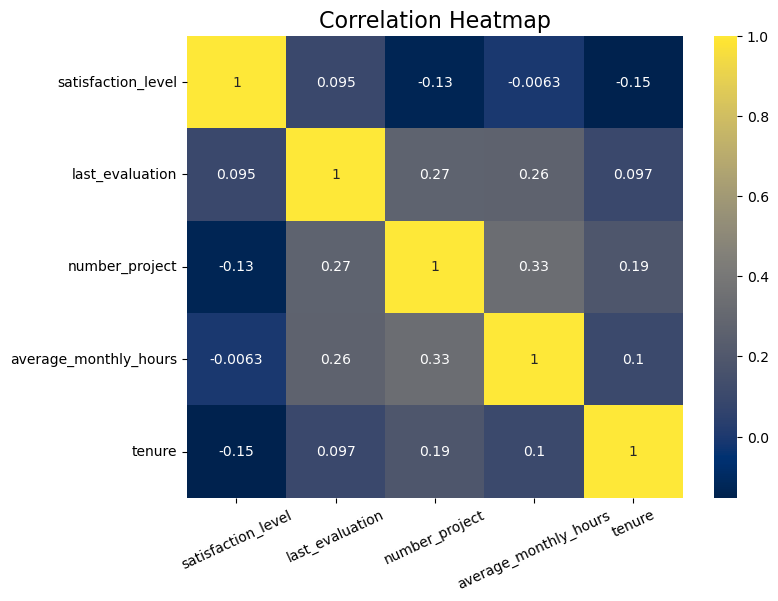

In [ ]:
# Heatmap with correlation of variables we've chosen based on the previous heatmap observations.
plt.figure(figsize=(8, 6))

# Use a colorblind-friendly colormap
sns.heatmap(
    df_enc[['satisfaction_level', 'last_evaluation', 'number_project',
            'average_monthly_hours', 'tenure']].corr(numeric_only=True),
    annot=True, cmap='cividis'
)
plt.xticks(rotation=25)
plt.title('Correlation Heatmap', fontsize=16);

Next, we visualize number of employees across department, comparing leavers and those who stayed.

As we've chosen logistic regression, it would be wise to remove the outliers in the 'tenure' identified earlier, since the model is sensitive to them.

In [ ]:
# Removal of outliers rows from 'tenure', by selecting those are not actual outliers.
# Saving them to new DataFrame.
df_logreg = df_enc[(df_enc['tenure'] >= lower_bounds) & (df_enc['tenure'] <= upper_bounds)]
df_logreg.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Now we isolate dependent (outcome) variable, we are trying to predict with the model.

In [ ]:
# Outcome (Y) variable isolation
y = df_logreg['left']
y.head()

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

We select features we want to use in our model. It should be varible that help us predict Y-variable.

In [ ]:
# Selecting only X variables(predictors) - removing the Y
X = df_logreg.drop('left', axis=1)
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,0,0,0,0,0,0,0,0,0,1,0,0


Now we can split the data into training and testing set.

We need to stratify Y-variable as the classes are not balanced.

In [ ]:
# Splitting the data - training & testing set - using 75/25 split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, stratify=y, random_state=42)

The construction of Logistic Regression model and fitting it to the training set.

In [ ]:
# Construct & fit of Log. Reg. model
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

Let's test logistic regression model on the test set to make predictions.

After that we create confusion matrix to visualize the results.

In [ ]:
# Predicting on X_test set.
y_pred = log_clf.predict(X_test)

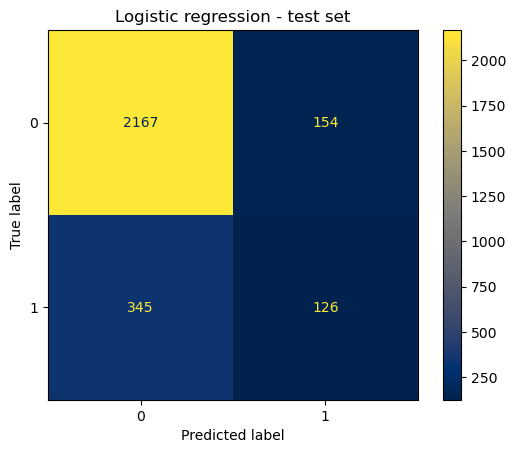

In [ ]:
## Confusion matrix

# Computation of values
cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Display creation for CM
log_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=log_clf.classes_)

# Confusion Matrix plot
log_disp.plot(values_format='', cmap='cividis')
plt.title('Logistic regression - test set');

The upper left quadrant - True negatives, the upper right quadrant - False positives, the bottom left - False negatives, the bottom right True positives.

**True negatives:** the number of people who did not leave, that the model accurately predicted as not leaving.

**False positives:** the number of people whot did not leave, that the model inaccurately predicted  as leaving.

**True positives:** the number of people who left, that model accurately predicted as leaving.

**False negatives:** the number of people who left, that model inaccurately predicted as not leaving.

In case of a perfect model we would see all true negative and true positive values, and not false
positive and false negative.

Now, we can create classification report that yields recall, precision, accuracy and f1 metrics to evaluate pefrmances of the model itself.

Before that we need to confirm class balance in the 'left' field. As we're dealing with binary classification task, the way of interpretation of the accuracy metrics depends on the class balance.

In [ ]:
left_percentage = round(df_logreg['left'].value_counts(normalize=True)*100,2)
left_percentage

0    83.15
1    16.85
Name: left, dtype: float64

The data is not perfectly balanced, but it's not too imbalanced neither. There is a 83/17 split, in this case we do not need to resample the data to make it more balanced.

In [ ]:
# Classification report
target_names=['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.45      0.27      0.34       471

                 accuracy                           0.82      2792
                macro avg       0.66      0.60      0.62      2792
             weighted avg       0.79      0.82      0.80      2792



The report yielded that the model achieved on employees who would not leave a f1 score of 80%, recall of 82%, precision of 79% (all weighted averages) and accuracy score of 80%.

### Tree-based Model

The implementation of Decision Tree and Random Forest

Isolation of the dependant variable

In [ ]:
# Isolate the Y variable
y = df_enc['left']

y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [ ]:
# Select the features
X = df_enc.drop('left',axis=1)

X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Split the data 75/25

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

#### Decision Tree - 1st round

Construct a decision tree model and set up cross-validated grid-search to search for the best model parameters.

In [ ]:
# Model instantiation
dt1_clf = DecisionTreeClassifier(random_state=0)

#Dictionary of hyperparameters to search over - cross-validation
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
            }
# Dictionary of scoring metrics
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# GridSearch instantiation
tree1 = GridSearchCV(dt1_clf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fit the DT model to the training data

In [ ]:
%%time
tree1.fit(X_train, y_train)

CPU times: total: 2.67 s
Wall time: 2.67 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'precision', 'roc_auc', 'f1', 'accuracy', 'recall'})

Now, we can proceed with identification of best parameters & the best AUC score of DT model on the training set.

In [ ]:
# Best parameters
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [ ]:
# Best AUC score
tree1.best_score_

0.969819392792457

Decision tree model achieved strong AUC score, that shows it can predict leaving employees very good.

The following function helps us retrieve cross-validation results from GridSearchCV, representing the average performance across all validation folds.

In [ ]:
def make_results(model_name: str, model_object, metric: str) -> pd.DataFrame:
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc

    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.
    '''
    # Mapping input metric to actual metric name in GridSearchCV
    metric_dict = {
        'auc': 'mean_test_roc_auc',
        'precision': 'mean_test_precision',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1',
        'accuracy': 'mean_test_accuracy'
    }

    # Extract CV results into a DataFrame
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Identify the best estimator based on the chosen metric
    best_index = cv_results[metric_dict[metric]].idxmax()
    best_estimator_results = cv_results.loc[best_index]

    # Extract relevant metrics
    results = {
        'model': model_name,
        'precision': best_estimator_results['mean_test_precision'],
        'recall': best_estimator_results['mean_test_recall'],
        'F1': best_estimator_results['mean_test_f1'],
        'accuracy': best_estimator_results['mean_test_accuracy'],
        'auc': best_estimator_results['mean_test_roc_auc']
    }

    # Create and return the results DataFrame
    return pd.DataFrame([results])

Getting all the scores with 'make_results' funtion

In [ ]:
# Get all scores
tree1_cv_results = make_results('decision tree1 cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree1 cv,0.914552,0.916949,0.915707,0.971978,0.969819


#### XGBoost - 1st round

In [ ]:
xgb1_clf = XGBClassifier(objective='binary:logistic', random_state=0)

cv_params = {'max_depth': [4,6],
             'min_child_weight': [3,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [5,10,15],
             #'subsample': [0.7],
             }

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

xgb1 = GridSearchCV(xgb1_clf, cv_params, scoring=scoring, cv=5, refit='roc_auc')

In [ ]:
%%time
# Fit the model
xgb1.fit(X_train, y_train)

CPU times: total: 55.5 s
Wall time: 8.31 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [5, 10, 15]},
             refit='roc_auc',
             scoring={'precision', 'roc_auc', 'f1', 'accuracy', 'recall'})

In [ ]:
# Check best AUC score on CV
xgb1.best_score_

0.9843580615474401

In [ ]:
# Check best params
xgb1.best_params_

{'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 15}

In [ ]:
# Get all CV scores
xgb1_cv_results = make_results('xgboost1 cv', xgb1, 'auc')
xgb1_cv_results

,model,precision,recall,F1,accuracy,auc
0,xgboost1 cv,0.98122,0.910247,0.944371,0.982208,0.984358


#### Random forest - 1st round

Construct a Random forest model and set up cross-validated grid-search to search for the best model parameters.

In [ ]:
# Model instantiation
rf1_clf = RandomForestClassifier(random_state=0)

# Dictionary of hyperparameters to search over - cross-validation
cv_params = {'max_depth': [3,5, None],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
            }
# Dictionary of scoring metrics
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# GridSearch instantiation
rf1 = GridSearchCV(rf1_clf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%%time
# Fit the model
rf1.fit(X_train, y_train)

CPU times: total: 20min 24s
Wall time: 20min 33s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'precision', 'roc_auc', 'f1', 'accuracy', 'recall'})

Now we define the function to pickle and read in the model.

We use functions above to save the model in a pickle file and then read it in.

We can proceed with identification of best parameters & the best AUC score of RF model on the training set.

In [ ]:
import pickle
# the path when we want to save the model
path = r'C:\Users\bajdikm\OneDrive - British Standards Institution\Desktop\Marek\Data Analyst_Scientist\Advanced Data Analytics\TikTok\6 ML'

In [ ]:
def write_pickle(path, model_object, save_as:str):
    '''
    In:
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)
print(f"Model saved to {path}")

Model saved to C:\Users\bajdikm\OneDrive - British Standards Institution\Desktop\Marek\Data Analyst_Scientist\Advanced Data Analytics\TikTok\6 ML


In [ ]:
def read_pickle(path, saved_model_name:str):
    '''
    In:
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out:
        model: the pickled model
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model
print("Model loaded successfully")

Model loaded successfully


In [ ]:
# Write pickle
write_pickle(path, rf1, 'hr_rf1')

In [ ]:
# Read pickle
rf1 = read_pickle(path, 'hr_rf1')

In [ ]:
# Check best AUC score on CV
rf1.best_score_

0.9804250949807172

In [ ]:
# Check best parameters
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 500}

Let's collect the scores on the training data for all three models.

In [ ]:
# Get all CV scores
rf1_cv_results = make_results('random forest1 cv', rf1, 'auc')

# Combine all results into a single DataFrame
all_results = pd.concat([tree1_cv_results, rf1_cv_results, xgb1_cv_results], ignore_index=True)

print(all_results)

               model  precision    recall        F1  accuracy       auc
0  decision tree1 cv   0.914552  0.916949  0.915707  0.971978  0.969819
1  random forest1 cv   0.950023  0.915614  0.932467  0.977983  0.980425
2        xgboost1 cv   0.981220  0.910247  0.944371  0.982208  0.984358


The XGBoost model generally outperformed the decision tree and random forest models across most evaluation metrics, with only a slight decrease in recall. The random forest model also showed better performance than the decision tree model in most metrics, with a negligible difference in recall. Therefore, XGBoost appears to be the best-performing model overall, followed by the Random forest and then the decision tree model.

Next, we evaluate XGBoost and Random forest on the test set.

We use a function to obtain all scores from the model's predictions, allowing for quick assessment and comparison of different models or configurations.

In [ ]:
def get_scores(model_name: str, model, X_test_data, y_test_data) -> pd.DataFrame:

    '''
    Generate a table of test scores.

    Parameters:
        model_name (str): How you want your model to be named in the output table
        model: A fit GridSearchCV object
        X_test_data: numpy array of X_test data
        y_test_data: numpy array of y_test data

    Returns:
        pd.DataFrame: DataFrame containing precision, recall, f1, accuracy, and AUC scores for the model
     '''
    # Make predictions using the best estimator
    preds = model.best_estimator_.predict(X_test_data)

    # Calculate the various evaluation metrics
    metrics = {
        'model': model_name,
        'precision': precision_score(y_test_data, preds),
        'recall': recall_score(y_test_data, preds),
        'f1': f1_score(y_test_data, preds),
        'accuracy': accuracy_score(y_test_data, preds),
        'AUC': roc_auc_score(y_test_data, preds)
    }

    # Create and return the results DataFrame
    return pd.DataFrame([metrics])

It represents performance on a single test set.

Now, apply the best performing models to make predictions on the test set.

In [ ]:
# Get xgb1 scores
xgb1_test_scores = get_scores('xgboost test', xgb1, X_test, y_test)

In [ ]:
# Get random forest1 scores
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)

In [ ]:
# Compare both scores
rf1_vs_xgb1 = pd.concat([rf1_test_scores, xgb1_test_scores], ignore_index=True)
rf1_vs_xgb1

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.964211,0.919679,0.941418,0.980987,0.956439
1,xgboost test,0.980519,0.909639,0.943750,0.981988,0.953019


**Overall Conclusion**

Both models perform exceptionally well, with slight differences in their metrics. The XGBoost model shows a higher precision and F1 score, while the Random Forest model exhibits marginally better recall and AUC. Given these results, the choice between the two models may depend on the specific priorities of the task:

- If minimizing false positives is critical, the XGBoost model is preferable due to its higher precision.
- If identifying true positives is more important, the Random Forest model is a better choice due to its higher recall and AUC.

Both models would be an excellent choice, but the XGBoost model has a slight edge in balanced performance as indicated by its F1 score and accuracy.

#### Feature Engineering

We might be questioning the high evaluation scores, suspecting potential data leakage. Data leakage happens when information that should be excluded during training is used, either because it appears in the test set or because it includes data that wouldn't be available when the model is deployed. Training with leaked data can result in an unrealistically high score that cannot be replicated in a production environment.

In this case, it’s probable that the company won't have satisfaction levels reported for all employees. Additionally, the `average_monthly_hours` column might be a source of data leakage. If employees have already decided to quit, or if management has identified them to be fired, they may be working fewer hours.

In the first round we included all features. The next round feature engineering will be incorporated to improve models.

We now proceed with dropping of `satisfaction level` and create new feature capturing whether an employee is overworked. It will be binary variable called `overworked`.

In [ ]:
df2 = df_enc.drop('satisfaction_level', axis=1)
df2.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# New 'overworked' feature is for now assigned to
df2['overworked'] = df2['average_monthly_hours']

# Inspection of max & min AVG monthly hours
print('Max hours:',df2['overworked'].max())
print('Min hours:',df2['overworked'].min())

Max hours: 310
Min hours: 96


The average number of monthly hours is approximately 166.67 for someone who works 50 weeks per year, 5 days per week, 8 hours per day.

We can define someone being overworked who works on average more than 175 hours per month.



In [ ]:
# Define 'overworked' - working more than 175 hours per week.
df2['overworked'] = (df2['overworked'] > 175).astype(int)

df2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int32

In [ ]:
# Drop the 'average_monthly_hours' column
df2 = df2.drop('average_monthly_hours', axis=1)

# Display first few rows of resulting dataframe
df2.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.86,5,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
2,0.88,7,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
3,0.87,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0.52,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


Let's isolate Y and X variables.

In [ ]:
# outcome variable
y = df2['left']

# predictors
X = df2.drop('left', axis=1)

In [ ]:
# Split the data, 75/25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

#### Decision tree - Round 2

In [ ]:
# Decision tree instance
dt2_clf = DecisionTreeClassifier(random_state=0)

# Cross-validation hyperparameters in dictionary
cv_params={'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
          }
# Scoring dictionary
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}


# GridSearch instance
tree2 = GridSearchCV(dt2_clf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%%time
tree2.fit(X_train, y_train)

CPU times: total: 2.81 s
Wall time: 2.89 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'precision', 'roc_auc', 'f1', 'accuracy', 'recall'})

In [ ]:
# Best parameters
tree2.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [ ]:
# Best score
tree2.best_score_

0.9586752505340426

The model performs exceptionally well, even in the absence of data on satisfaction levels and worked hours.

Now we can have a look at the other scores.

In [ ]:
# Get all CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
tree2_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree2 cv,0.856693,0.903553,0.878882,0.958523,0.958675


Most of the scores are lower, but that's expected in regards of prior features reduction for the second round of tests.

#### Random forest - Round 2

In [ ]:
# Model instantiation
rf2_clf = RandomForestClassifier(random_state=0)

# Dictionary of hyperparameters to search over - cross-validation
cv_params = {'max_depth': [3,5, None],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
            }
# Dictionary of scoring metrics
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# GridSearch instantiation
rf2 = GridSearchCV(rf2_clf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

SyntaxError: unterminated string literal (detected at line 16) (618146308.py, line 16)

In [ ]:
%%time
# 7 minutes run time
rf2.fit(X_train, y_train)

In [ ]:
# Write pickle
#write_pickle(path, rf2, 'hr_rf2')

In [ ]:
# Read in pickle
#rf2 = read_pickle(path, 'hr_rf2')

In [ ]:
# Check best params
rf2.best_params_

In [ ]:
# Check best AUC score on CV
rf2.best_score_

In [ ]:
# Get all CV scores
rf2_cv_results = make_results('random forest2 cv', tree2, 'auc')
rf2_cv_results

In [ ]:
xgb2_clf = XGBClassifier(objective='binary:logistic', random_state=0)

cv_params = {'max_depth': [4,6],
             'min_child_weight': [3,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [5,10,15],
             #'subsample': [0.7],
             }

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

xgb2 = GridSearchCV(xgb2_clf, cv_params, scoring=scoring, cv=5, refit='roc_auc')

In [ ]:
%%time
xgb2.fit(X_train, y_train)


In [ ]:
# write in pickle file
#write_pickle(path, xgb2, 'hr_xgb2')

In [ ]:
# read in pickle file
#xgb2 = read_pickle(path, 'hr_xgb2')

In [ ]:
xgb2.best_score_

In [ ]:
xgb2.best_params_

In [ ]:
xgb2_cv_results = make_results('xgboost2 cv', xgb2, 'auc')
xgb2_cv_results

In [ ]:
all_models = pd.concat([tree2_cv_results,rf2_cv_results, xgb2_cv_results], ignore_index=True)
all_models

In [ ]:
# Get predictions on test data
xgb2_test_scores = get_scores('xgboost2 test', xgb2, X_test, y_test)
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)

In [ ]:
# Display the combined test scores
rf2_vs_xgb2_test = pd.concat([rf2_test_scores, xgb2_test_scores], ignore_index=True)
rf2_vs_xgb2_test

Both models exhibit strong performance in predicting employee turnover, but XGBoost stands out as the champion model for several reasons:

Higher Precision: XGBoost (0.89697) vs. Random Forest (0.870406)
-  XGBoost better avoids false positives, crucial for preventing unnecessary interventions.

Higher F1-Score: XGBoost (0.89426) vs. Random Forest (0.8867)
-  The F1-score indicates XGBoost has a better balance between precision and recall.

Higher Accuracy: XGBoost (0.964977) vs. Random Forest (0.961641)
-  XGBoost correctly classifies a slightly higher percentage of instances.

Comparable AUC: XGBoost (0.935583) vs. Random Forest (0.938407)
-  The difference in AUC is minimal (0.002824), favoring Random Forest slightly.

Although Random Forest has a higher recall (0.903614 vs. 0.891566), XGBoost's superior performance in precision, F1-score, and accuracy might make it the recommended model for predicting employee turnover.

Let's create confusion matrices that provide the most detailed and invaluable breakdown of predictions on test set.

In [ ]:
y_preds = xgb2.best_estimator_.predict(X_test)

# Array values for confusion matrix
cm = confusion_matrix(y_test, y_preds, labels=xgb2.classes_)

# Plot CM
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb2.classes_)
disp.plot(values_format='', cmap='cividis')
plt.title('XGboost2 - test set');

The XGboost predicted fewer false positives (51) than false negatives (54), meaning it is more likely to miss employees who will quit or get fired, compared to incorrectly identifying employees as quitting or getting fired when they are not. Ideally, to minimize employee attrition, the model should aim for fewer false negatives, even if it results in more false positives, to ensure at-risk employees are identified and appropriate retention measures can be taken. Nevertheless, the model still demonstrates strong predictive capability.

In [ ]:
# Predictions
y_preds = rf2.best_estimator_.predict(X_test)

# Array values for confusion matrix
cm = confusion_matrix(y_test, y_preds, labels=rf2.classes_)

# Plot CM
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf2.classes_)
disp.plot(values_format='', cmap='cividis')
plt.title('Random Forest2 - test set');

The Random forest predicted more false positives(67) than false negatives(48), that means the model is more likely to incorrectly identify employees as quitting or getting fired (when they actually stay) compared to missing employees who will quit or get fired.

The goal of the Salifort HR department is to minimize employee attrition, as the cost of an employee leaving is very high. Therefore, the champion model is a Random Forest that minimizes false negatives, which is more important even at the expense of more false positives. This approach ensures that most employees who are at risk of quitting or being fired are identified and can be addressed proactively.

Now we can inspect the decison tree's splits and most important features in the random forest.

### Decision tree splits

Decision trees provide excellent transparency, making them intuitive and easy to visualize. By examining the splits at each node, one can understand how the model makes decisions, revealing the important features and thresholds it uses for predictions.


Additionally, analyzing these splits helps identify relationships between features and the target variable, highlighting how they interact and influence the model's outcomes. This insight enhances our understanding of the underlying patterns in the data.

In [ ]:
plt.figure(figsize=(85, 20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns,
         class_names={0:'stayed', 1:'left'}, filled=True)
plt.show()

In [ ]:
# Random forest feature importance
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_,
                                 columns=['gini_importance'],
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Filtering only features greater than 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

We can create barplots to visualize decision tree and random forest feature importances.

In [ ]:
#DT barplot importance
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h',
           )
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

We can observe from the barplot that last_evaluation, number_project, tenure and overworked have the highest importance.
These variables are most heplful predictors for the target variable.

#### Random forest feature importance

In [ ]:
# Feature importances
rf_imprt = rf2.best_estimator_.feature_importances_

# Identifies the indices of the 10 most important features of the RF model's best estimator.
# -10 means that the indices of the 10 largest values are moved to the last 10 positions of the array
# [-10:] retrieves the indices of these top 10 important features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

# Gets column labels of top 10 features - feat: a list or array containing the feature names
feat = X.columns[ind]

# Filter 'feat_impt' to be made of top 10 feature importance scores
rf_imprt = rf_imprt[ind]

# Creates a DataFrame with 2 columns: "Feature" and "Importance".
y_df = pd.DataFrame({"Feature":feat,"Importance":rf_imprt})
# Sorts the df by importance
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
# The argument 111 means "1x1 grid, first subplot", one subplot in the figure.
ax1 = fig.add_subplot(111)


# Creates horizontal barplot
y_sort_df.plot(kind='barh', ax=ax1, x="Feature", y="Importance", color='skyblue')

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)

plt.show()

The barplot shows the feature importances differ between an XGBoost model and a Decision Tree model, it’s not necessarily a problem but an indication of how each model captures relationships in the data


**Summary of Feature Importances Across Models:**

We've observed that the feature importances differ between our XGBoost and Decision Tree models. This variation is due to the inherent differences in how each model learns from the data:

 -  Decision Trees focus on finding the best single splits at each step, leading to feature importances based on immediate impurity reduction.
 -  XGBoost, as an ensemble method, aggregates feature importances across multiple trees, capturing more complex interactions and correcting previous errors.

Given these differences, each model may highlight different features as important. For instance, XGBoost might identify more subtle but impactful patterns due to its iterative learning process.

**Summary for Stakeholders:**

When evaluating our machine learning models, the primary focus is on the model’s performance and accuracy. This ensures that we make the most accurate predictions on new data, directly impacting our decision-making processes and business outcomes.

While consistent feature importance across different models can enhance our understanding and confidence in key features, it is secondary to achieving high predictive performance. Our champion model will be selected based on robust performance metrics such as accuracy, precision, recall, and AUC, ensuring it generalizes well to unseen data.

The barplot shows that random forest has the same importance features as decision tree model in the same order as well. These variables are most helpful in predicting the target variable 'left'.

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_sort_df is your DataFrame and ax1 is your axis object

# Create a larger figure
fig, ax1 = plt.subplots(figsize=(7, 5))  # Adjust the figsize values as needed

# Create the horizontal bar plot
y_sort_df.plot(kind='barh', ax=ax1, x="Feature", y="Importance", color='skyblue')

# Set plot title and labels
ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=16)
ax1.set_ylabel("Feature", fontsize=12)
ax1.set_xlabel("Importance", fontsize=12)

# Adjust the tick parameters for better readability
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)

# Display the plot
plt.show()


# pacE: Execute Stage


## Evaluation metrics

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example.
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.






### Results and Evaluation



**Logistic Regression:** model achieved precision of 80%, recall of 83%, f1-score of 80% (all weighted averages), and accuracy of 83%, on the test set.



**Tree-based Machine Learning:** After conducting feature engineering, the decision tree model achieved AUC of 93.8%, precision of 87.0%, recall of 90.4%, f1-score of 88.7%, and accuracy of 96.2%, on the test set. The random forest slightly outperformed the decision tree model.

### Conclusion and Recommendations

The models and their extracted feature importances indicate that employees at the company are overworked.

To improve company's employees retention, the following recommendations could be presented to stakeholders:

* Limit the number of projects assigned to each employee.
* Consider promoting employees who have been with the company for at least four years, or investigate why these long-tenured employees are so dissatisfied.
* Either reward employees for working longer hours or eliminate the requirement for them to do so
* Ensure employees are informed about the company's overtime pay policies. If expectations around workload and time off are unclear, make them explicit.
* Conduct company-wide and team-specific discussions to understand and improve the company work culture.
* High evaluation scores should not be reserved for employees working over 200 hours per month. Implement a proportionate scale to reward employees based on their contributions and effort.

### Next Steps

It may still be reasonable to have concerns about data leakage. It would be prudent to analyze how predictions change when the last_evaluation feature is removed. If evaluations are infrequent, predicting employee retention without this feature could be valuable. Conversely, if evaluation scores significantly influence whether an employee stays or leaves, it might be useful to shift focus and predict performance scores instead. The same consideration applies to the satisfaction score.

We can try to build a K-means model on this data and analyze clusters as a next project.